# HMM for Stock Market

## 1. Why is Detecting Market Regime Shift Important for Quantitative Trading or Investing?

Detecting market regime shifts is essential in quantitative trading and investing because financial markets are not static; they undergo periods of distinct behaviors, such as bull markets (rising prices, low volatility), bear markets (falling prices, high volatility), or sideways/trending phases influenced by economic events, policy changes, geopolitical tensions, or investor sentiment. These shifts lead to non-stationarities in asset returns, including changes in means, variances, correlations, and risk profiles, which can render traditional models (like mean-reversion or trend-following) ineffective or risky if not adapted.

**Key reasons for importance:**

1. Strategy Optimization: Different regimes favor different strategies. For instance, momentum trading works well in trending regimes but fails in volatile ones. Detecting shifts allows quants to switch strategies dynamically, improving performance and alpha generation.

2. Risk Mitigation: Regimes like high-volatility periods increase drawdown risks. Early detection enables position sizing adjustments, hedging, or exiting trades to protect capital.

3. Portfolio Allocation: In multi-asset portfolios, correlations change across regimes (e.g., stocks and bonds may decouple in crises). Regime awareness helps rebalance allocations to minimize losses and capture opportunities.

4. Improved Forecasting: Ignoring shifts leads to poor predictions; incorporating them enhances models for better entry/exit signals, reducing false positives.


Overall, it turns reactive trading into proactive, data-driven decision-making, boosting returns while controlling drawdowns in uncertain markets.

## 2. How Are Hidden Markov Models Usually Applied in Quantitative Trading or Investing?

Hidden Markov Models (HMMs) are applied in quantitative trading to model and detect latent market states (regimes) based on observable data like prices, returns, or volumes. They assume markets transition between hidden states (e.g., bull, bear, neutral) with probabilities, using observations to infer current regimes. Common applications include:

* Regime Detection for Strategy Switching: HMMs classify market phases to activate/deactivate strategies. E.g., long-only in bull regimes, short-selling in bear.

* Risk Management: Integrate HMM into overlays to filter trades; avoid high-risk positions in volatile regimes.

* Prediction and Signal Generation: Forecast next states for buy/sell signals or volatility estimates.

* Portfolio Optimization: Adjust asset weights based on regime probabilities, enhancing Sharpe ratios.

**Specific examples:**

* S&P 500 Price Prediction and Trading (from MDPI Journal): HMM models S&P 500 returns as emissions from hidden states (e.g., low/high volatility). Trained on historical data, it predicts regimes to generate trading signals: buy in stable growth, sell in downturns. Results showed improved accuracy over ARIMA models, with backtested returns outperforming buy-and-hold by 10-15% annually.

* Intraday Buy Signal Generation (from QuantConnect Micro-Study): A 3-state HMM on liquid stocks (e.g., AAPL) detects intraday regimes (uptrend, downtrend, choppy). It generates timely buy signals in uptrends, tested on 1-min data, yielding 5-8% excess returns with lower volatility via regime filtering.

* Directional Change Trading with HMM (from QuantInsti Blog): HMM estimates regimes from directional change indicators (price reversals). Applied to forex pairs like EUR/USD, it predicts shift points for entry/exit, reducing whipsaws and improving win rates by 20% in volatile markets.

* VN-Index Regime Categorization (from ResearchGate Paper): In emerging markets like Vietnam, HMM categorizes regimes (expansion/contraction) using Black-Scholes framework, adjusting option pricing and hedging strategies for better risk-adjusted returns.

For code, using hmmlearn for AAPL daily returns regime detection with 3 states, visualization, and simple signals. Libraries: yfinance, numpy, hmmlearn, matplotlib.

In [2]:
import yfinance as yf
import numpy as np
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [3]:
# Fetch AAPL data (last 10 years)
symbol = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=365*10)
data = yf.download(symbol, start=start_date, end=end_date)
returns = data['Close'].pct_change().dropna().values.reshape(-1, 1)  # Daily returns as observations

C:\Users\86189\AppData\Local\Temp\ipykernel_42396\2840476371.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


### Model Fitting and Prediction

In [4]:
# Fit Gaussian HMM with 3 states
model = GaussianHMM(n_components=3, covariance_type='full', n_iter=1000, random_state=42)
model.fit(returns)

# Predict hidden states (regimes)
hidden_states = model.predict(returns)

# Add to DataFrame
df = data.iloc[1:].copy()  # Align with returns
df['Returns'] = returns.flatten()
df['Regime'] = hidden_states

# Print transition matrix, means, vars
print("Transition Matrix:\n", model.transmat_)
print("\nMeans and Vars of Each State:")
for i in range(model.n_components):
    print(f"State {i}: Mean = {model.means_[i][0]:.4f}, Var = {np.diag(model.covars_[i])[0]:.4f}")

D:\anaconda3\envs\py311-tradingagents-cn\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


Transition Matrix:
 [[3.65180922e-04 9.99580694e-01 5.41251621e-05]
 [9.41538242e-01 3.21116866e-03 5.52505897e-02]
 [8.57388558e-02 1.46892252e-02 8.99571919e-01]]

Means and Vars of Each State:
State 0: Mean = 0.0010, Var = 0.0002
State 1: Mean = 0.0019, Var = 0.0001
State 2: Mean = -0.0006, Var = 0.0010


### Generate Signals and Visualization

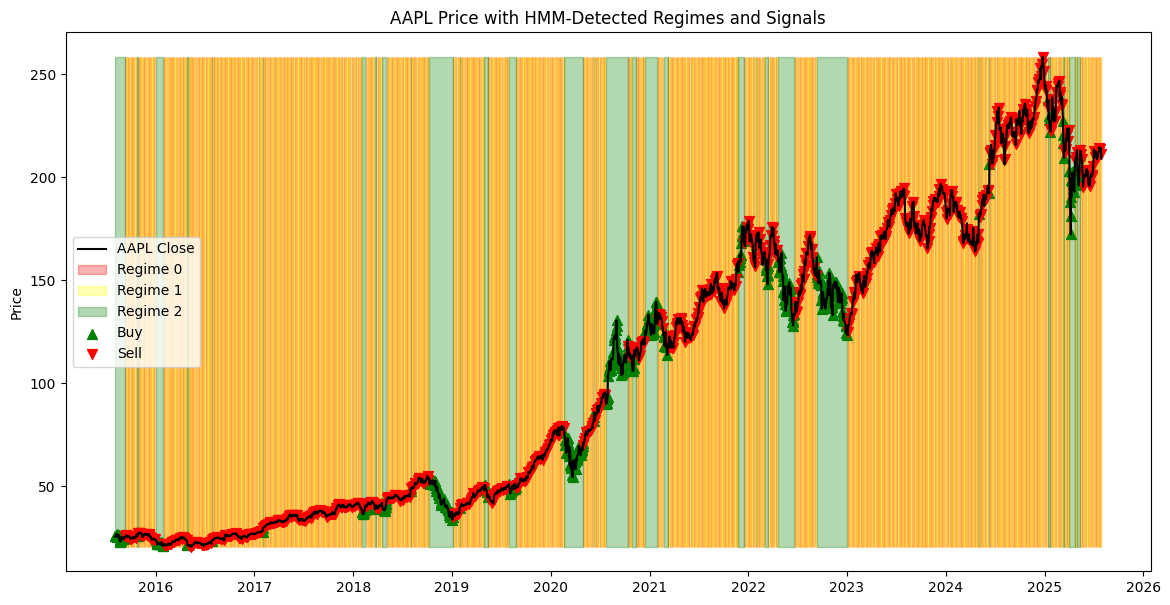

In [5]:
# Simple signals: Assume state 0=bear (sell=-1), state 2=bull (buy=1), state 1=neutral (hold=0)
df['Signal'] = 0
df.loc[df['Regime'] == 0, 'Signal'] = -1
df.loc[df['Regime'] == 2, 'Signal'] = 1

# Plot price with regimes
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(df.index, df['Close'], color='black', label='AAPL Close')
ax1.set_ylabel('Price')

# Color regimes
regime_colors = {0: 'red', 1: 'yellow', 2: 'green'}
for regime, color in regime_colors.items():
    ax1.fill_between(df.index, df['Close'].min(), df['Close'].max(), where=(df['Regime'] == regime), color=color, alpha=0.3, label=f'Regime {regime}')

# Add signals
buy = df[df['Signal'] == 1]
sell = df[df['Signal'] == -1]
ax1.scatter(buy.index, buy['Close'], marker='^', color='green', s=50, label='Buy')
ax1.scatter(sell.index, sell['Close'], marker='v', color='red', s=50, label='Sell')

ax1.legend()
plt.title('AAPL Price with HMM-Detected Regimes and Signals')
plt.show()

**References**

Nguyen, N. Hidden Markov Model for Stock Trading. Int. J. Financial Stud. 2018, 6, 36. https://doi.org/10.3390/ijfs6020036

From QuantConnect Micro-Study https://www.quantconnect.com/research/17900/intraday-application-of-hidden-markov-models/

From QuantInsti Blog https://blog.quantinsti.com/markov-model/

Tuyen, Luc. (2013). Markov Financial Model Using Hidden Markov Model. International Journal of Applied Mathematics and Statistics. 40. 72-83. 
